In [34]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime
from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [2]:
def evraz_metric(true_t, predict_t, true_c, predict_c):

    delta_c = np.abs(np.array(true_c) - np.array(predict_c))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true_t) - np.array(predict_t))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(predict_c)

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [5]:
path = Path('../../data/2021_evraz')

In [6]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 167)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,2950,2960,980,0,0,0,14080,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,2930,0,960,0,0,1060,18830,0,0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,2990,2960,1050,0,0,990,16080,0,0


In [7]:
test = pd.read_pickle(path.joinpath('test_all.pkl'))
print(test.shape)
test.head(3)

(780, 165)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1310,1670,0,0,0,0,13960,0,0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,0,0,0,0,0,0,15290,0,50
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,0,0,0,0,0,0,20010,0,1400


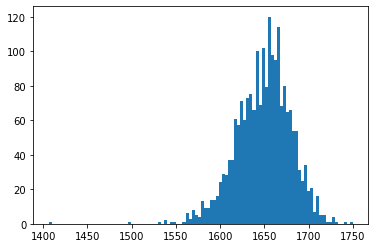

In [8]:
plt.hist(target_train['TST'], bins=100);

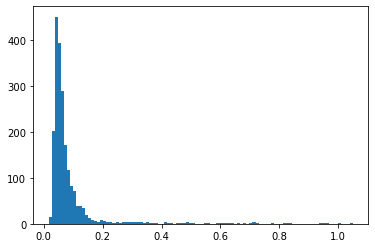

In [9]:
plt.hist(target_train['C'], bins=100);

**Сделаем логарифмирование целевой функции С.**

In [7]:
# target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
# target_train['C'] = np.log10(target_train['C'])

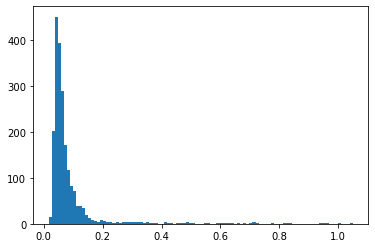

In [10]:
plt.hist(target_train['C'], bins=100);

In [11]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
target_train['C'] = np.log(target_train['C'])

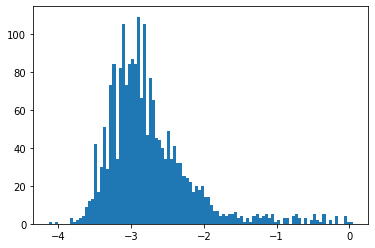

In [12]:
plt.hist(target_train['C'], bins=100);

In [35]:
# target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
# target_train['C'] = np.log2(target_train['C'])

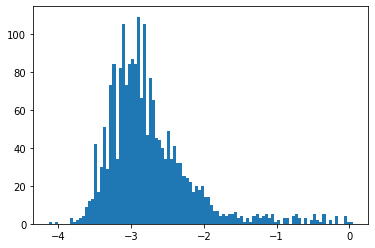

In [13]:
plt.hist(target_train['C'], bins=100);

In [14]:
target_train['C']

0      -2.813411
1      -2.333044
2      -2.396896
3      -0.891598
4      -2.120264
          ...   
2058   -1.931022
2059   -2.441847
2060   -1.958995
2061   -1.309333
2062   -1.698269
Name: C, Length: 2063, dtype: float64

In [15]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

In [37]:
np.linspace(1, 10000, 10, dtype=int)

array([    1,  1112,  2223,  3334,  4445,  5556,  6667,  7778,  8889,
       10000])

  0%|          | 0/20 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 2.9446, train-score 2 = 0.0005
valid-score 1 = 603.2629, valid-score 2 = 0.2086
Train metric =  0.84
Valid metric =  0.3366
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 2.42, train-score 2 = 0.0005
valid-score 1 = 439.3116, valid-score 2 = 0.1657
Train metric =  0.8618
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.0052, train-score 2 = 0.0006
valid-score 1 = 510.3918, valid-score 2 = 0.1845
Train metric =  0.8342
Valid metric =  0.3826
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 2.1468, train-score 2 = 0.0005
valid-score 1 = 473.2893, valid-score 2 = 0.1397
Train metric =  0.8586
Valid metric =  0.3835
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 2.3265, train-score 2 = 0.0007
valid-score 1 = 440.5067, valid-score 2 = 0.1541
Train metric =  0.8362
Valid metric

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 3.7105, train-score 2 = 0.0009
valid-score 1 = 573.5785, valid-score 2 = 0.1462
Train metric =  0.8391
Valid metric =  0.3608
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 3.9567, train-score 2 = 0.0011
valid-score 1 = 440.0527, valid-score 2 = 0.1975
Train metric =  0.8012
Valid metric =  0.3596
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 3.6123, train-score 2 = 0.0008
valid-score 1 = 512.356, valid-score 2 = 0.1744
Train metric =  0.8464
Valid metric =  0.3789
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 4.8201, train-score 2 = 0.0006
valid-score 1 = 460.3127, valid-score 2 = 0.1255
Train metric =  0.868
Valid metric =  0.3981
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 7.4116, train-score 2 = 0.001
valid-score 1 = 377.8142, valid-score 2 = 0.1659
Train metric =  0.8259
Valid metri

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 19.0857, train-score 2 = 0.0059
valid-score 1 = 537.7636, valid-score 2 = 0.1285
Train metric =  0.6518
Valid metric =  0.3644
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 22.8057, train-score 2 = 0.0048
valid-score 1 = 430.1689, valid-score 2 = 0.2384
Train metric =  0.6661
Valid metric =  0.3705
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 19.7559, train-score 2 = 0.0041
valid-score 1 = 469.2623, valid-score 2 = 0.1675
Train metric =  0.6909
Valid metric =  0.3753
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 17.8416, train-score 2 = 0.0062
valid-score 1 = 463.332, valid-score 2 = 0.1312
Train metric =  0.6426
Valid metric =  0.3944
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 22.5994, train-score 2 = 0.0049
valid-score 1 = 349.8997, valid-score 2 = 0.1552
Train metric =  0.6732
Vali

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 110.4654, train-score 2 = 0.0297
valid-score 1 = 507.4241, valid-score 2 = 0.1118
Train metric =  0.5497
Valid metric =  0.3789
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 113.5522, train-score 2 = 0.0279
valid-score 1 = 410.8063, valid-score 2 = 0.1623
Train metric =  0.5485
Valid metric =  0.3995
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 113.8217, train-score 2 = 0.0269
valid-score 1 = 437.4257, valid-score 2 = 0.1613
Train metric =  0.55
Valid metric =  0.391
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 107.7378, train-score 2 = 0.0287
valid-score 1 = 428.949, valid-score 2 = 0.1234
Train metric =  0.5454
Valid metric =  0.409
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 118.5429, train-score 2 = 0.0273
valid-score 1 = 317.3773, valid-score 2 = 0.1394
Train metric =  0.5533
Val

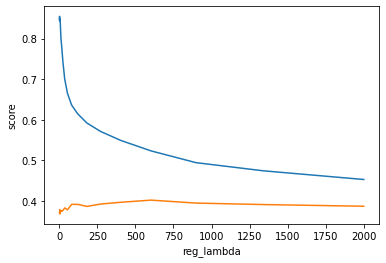

In [39]:
cv_strategy = KFold(n_splits=5)

reg_lambda, current_score_train, current_score_valid  = [], [], []

for i in tqdm(np.geomspace(1, 2000, 20, dtype=int)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(reg_lambda=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(reg_lambda=i, random_state=1),
        metric=mean_squared_error, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    reg_lambda.append(i)

plt.plot(reg_lambda, current_score_train)
plt.plot(reg_lambda, current_score_valid)
plt.xlabel('reg_lambda')
plt.ylabel('score')
plt.show();

In [41]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

reg_lambda = 600

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(reg_lambda=reg_lambda, random_state=1), 
    estimator_2=xgb.XGBRegressor(reg_lambda=reg_lambda, random_state=1),
    metric=mean_squared_error, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 144.5638, train-score 2 = 0.0395
valid-score 1 = 500.8711, valid-score 2 = 0.1156
Train metric =  0.5209
Valid metric =  0.3741
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 150.2365, train-score 2 = 0.0378
valid-score 1 = 408.3727, valid-score 2 = 0.1373
Train metric =  0.5276
Valid metric =  0.4007
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 150.2695, train-score 2 = 0.0366
valid-score 1 = 443.7311, valid-score 2 = 0.1551
Train metric =  0.5233
Valid metric =  0.3983
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 140.2599, train-score 2 = 0.0393
valid-score 1 = 417.1183, valid-score 2 = 0.1251
Train metric =  0.5224
Valid metric =  0.4393
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 157.035, train-score 2 = 0.0378
valid-score 1 = 314.744, valid-score 2 = 0.1354
Train metric =  0.5188


In [42]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(np.exp(test_pred_2)).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1653.656494,0.045847
1,512327,1668.243896,0.055107
2,512328,1653.902832,0.085800
3,512331,1635.294678,0.093378
4,512333,1648.091309,0.147845


In [44]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'../submits/xgb_n-tree-17_all_feats_log10_exp_metric_mse_reg_lambda600_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  ../submits/xgb_n-tree-17_all_feats_log10_exp_metric_mse_reg_lambda600_2021-11-05_01-01-39.csv

 File saved to disk!
